# Установка пакетов

In [1]:
!pip install mapclassify  # Нужно для корректного построения карт

     |████████████████████████████████| 51kB 1.1MB/s 
  Created wheel for mapclassify: filename=mapclassify-2.2.0-cp36-none-any.whl size=47028 sha256=badc04f4456ebcbb142e5948a7ac36cdd1af8a5a14ee3e1aad756233a336b6a7
  Stored in directory: /root/.cache/pip/wheels/96/0c/c1/b2bce9fc10da2e6c6befc9fe5929adca7c71b7c4abd1fc42f0
Successfully built mapclassify


In [2]:
!pip install geopandas  # Модуль для карт

     |████████████████████████████████| 931kB 2.0MB/s 
     |████████████████████████████████| 14.7MB 300kB/s 
     |████████████████████████████████| 10.9MB 36.2MB/s 


In [3]:
import pandas as pd 
import numpy as np  
import seaborn as sns  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import geopandas as gpd  
import matplotlib.pyplot as plt  

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

# Загрузка данных

Я взяла данные отсюда: https://www.kaggle.com/unsdsn/world-happiness
Это отчёт об уровне счастья по странам. Я буду обрабатывать только данные за 2019 год. <br/>
Помимо среднего значения счастья по шкале от 0 до 10, которое указали учаcтники опроса, в таблице содержатся различные факторы, которые потенциально могут влиять на уровень счастья. <br/> 
В этом задании я поставила себе две задачи: 1) визуализировать на карте уровень счастья по странам и 2) научить модель по факторам предсказывать уровень счастья , возможно, выяснив, какой из факторов более всех на влияет на уровень счастья.

In [0]:
data_folder = 'data/'  # Папки с исходными данными
df_2019 = pd.read_csv(data_folder + '2019.csv')

In [7]:
df_2019.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410


Overall rank: позиция в рейтинге стран по счастью<br/>
Country or region: страна или регион<br/>
Score: уровень счастья <br/>
GDP per capita: ВВП на душу населения<br/>
Social support: социальная поддержка<br/>
Healthy life expectancy: ожидаемое здоровье<br/>
Freedom to make life choices: свобода делать жизненные решения<br/>
Generosity: щедрость<br/>
Perceptions of corruption: индекс восприятия коррупции

# Карты

Для начала интересно визуализировать уровень счастья (можно связанные с ним факторы) на карте

In [0]:
def worldplot(df, column, title='', cmap="RdYlGn"):
    """
    Функция, принимающая на вход датафрейм и название столбца со значением,
    которое хочется изобразить на карте. Также можно ввести заголовок карт и
    цветовую гамму.
    """
    plotmap = df.plot(column=column,
                      figsize=(15, 10),
                      legend=True,
                      k=9,
                      edgecolor='black',
                      cmap=cmap,
                      scheme="equal_interval",
                      missing_kwds={
                                 'color': 'lightgrey',
                                "hatch": "///",
                                "label": "Нет данных"})
    plotmap.set_axis_off()
    plotmap.get_legend().set_bbox_to_anchor((.17, .6))
    plotmap.set_title(title, fontdict={'fontsize': 20}, loc='left')
    return plotmap


# Функция, использующая функцию worldplot и рисующая только Европу
def europeplot(df, column, title='', cmap="RdYlGn"):
    df = df[df.continent == "Europe"][df.name != 'Russia']
    return worldplot(df, column, title=title, cmap=cmap)

Сначала загрузила файл с границами стран для geopandas

In [0]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [11]:
print(sorted(df_2019['Country or region'].unique()))
print(sorted(world.name.unique()))

['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi

Надо привести названия стран в единый вид

In [0]:
world = world.replace('United States of America', 'United States')
world = world.replace('Palestine', 'Palestinian Territories')
world = world.replace('N. Cyprus', 'Northern Cyprus')
world = world.replace('Czechia', 'Czech Republic')
world = world.replace('Dominican Rep.', 'Dominican Republic')
world = world.replace('Papua New Guinea', 'Guinea')
world = world.replace('Dem. Rep. Congo', 'Congo (Kinshasa)')
world = world.replace('Congo', 'Congo (Brazzaville)')
world = world.replace('Central African Rep.', 'Central African Republic')
world = world.replace('Bosnia and Herz.', 'Bosnia and Herzegovina')
world = world.replace('S. Sudan', 'South Sudan')
world = world.replace('Trinidad and Tobago', 'Trinidad & Tobago')

Потом надо объединить датафреймы: тот, который и анализирую и тот, который содержит информацию о форме границ стран.

In [0]:
map_2019 = world.merge(df_2019,
                       how='left',
                       left_on='name',
                       right_on='Country or region')

In [15]:
map_2019.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",153.0,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147


Теперь можно использовать функцию wordplot для того, чтобы нарисовать карту. 

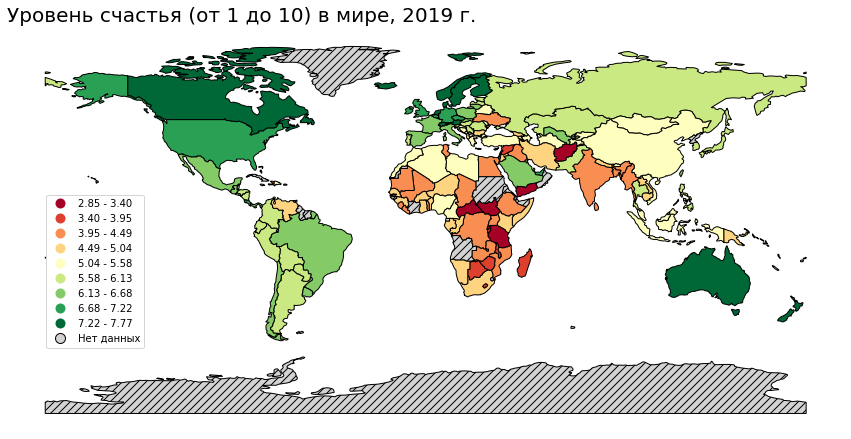

In [16]:
worldplot(map_2019,
          "Score",
          title="Уровень счастья (от 1 до 10) в мире, 2019 г.")

Теперь только для Европы

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


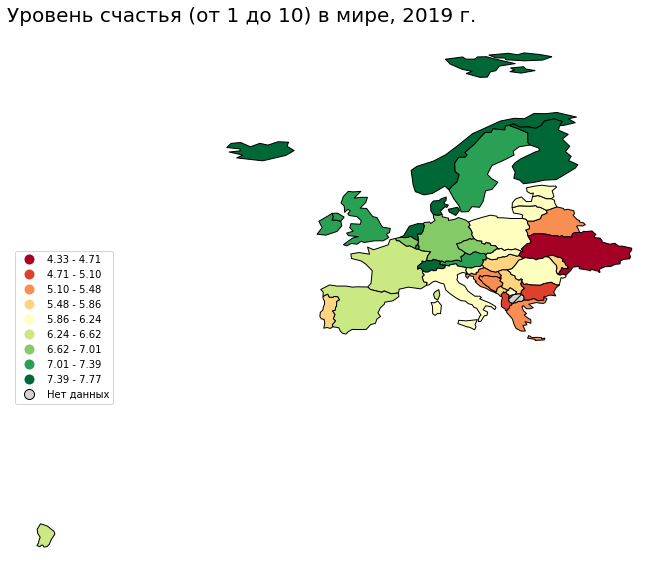

In [17]:
europeplot(map_2019,
           "Score",
           title="Уровень счастья (от 1 до 10) в мире, 2019 г.")

Можно и другие столбцы показать на карте, например, индекс восприятия коррупции.

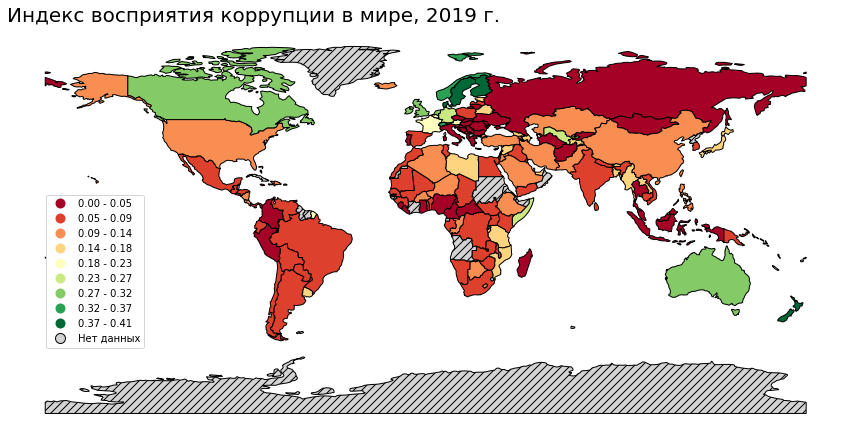

In [18]:
worldplot(map_2019,
          "Perceptions of corruption",
          title="Индекс восприятия коррупции в мире, 2019 г.")

# Предсказание уровня счастья

Теперь займусь второй задачей.<br/>
Для начала обучу модель предсказывать уровень счастья по значениям факторов. Уровень счастья непрерывен, так что имеет смысл использовать регрессию.<br/>
После этого посмотрю, какой из факторов вносит наибольший вклад.

In [19]:
df_2019.head(2)

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410


## Линейная регрессия

In [20]:
X = df_2019.iloc[:, 3:].to_numpy()
y = df_2019.iloc[:, 2].to_numpy()

# Разделяем выборку на тренировочную и  тестовую
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

reg = linear_model.LinearRegression()  # Инициализация модели
reg.fit(X_train, y_train)  # Тренировка модели
y_pred = reg.predict(X_test)  # Предсказание уровня счастья

# Теперь посчитаем с.к.о. и коэф. детерминации
print('Средняя квадратичная ошибка: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Коэффициент детерминации: %.2f'
      % r2_score(y_test, y_pred))

Средняя квадратичная ошибка: 0.41
Коэффициент детерминации: 0.60


Коэффициет детерминации > 0.5, так что модель имеет смысл. Теперь посмотрю на коэффициенты предикторов

In [21]:
reg.coef_

array([0.7507166 , 1.23232472, 0.93094484, 1.48981335, 0.27037842,
       1.11243118])

Наибольший вклад у того фактора, коэффициент при котором больше. Выясню его.

In [22]:
df_2019.columns[reg.coef_.argmax() + 3]

'Freedom to make life choices'

In [23]:
df_2019.columns[reg.coef_.argmin() + 3]

'Generosity'

Итоги:<br/>
1) Нарисована карта уровня счастья по странам. Можно смотреть :-)<br/>
2) Обучена модель для предсказания уровня счастья. Наибольший вклад в уровень счастья вносит свобода принимать жизненные решения в стране, а наименьший - щедрость жителей страны, но всё же вносит<br/>